In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
from itertools import product

# Estimating the Input Uncertainty of the One-Group Cross-Section Parameters

The one-group cross-section is in essence a weighted sum of the energy dependent cross-section, using the neutron flux spectrum as weights.
For a reaction $j$, it can be writen as:
$$\sigma_{i,one-group} = \frac{\sum_{E_{i}}\phi_{E_{i}}\times\sigma_{j,E_{i}}}{\sum_{E_{i}}\phi_{E_{i}}}$$

Gaussian propagation of uncertainty can be used to propagate the uncertainty of the cross-section in each energy bin to an overall uncertainty $u_{one-group}$ of the one-group cross-section:
$$u_{one-group}^2 = \frac{\sum_{i,k}\phi_i\phi_k\,rcov_{i,k}\sigma_i\sigma_k}{\sum_{E_{i}}\phi_{E_{i}}}$$
Here, both indices $i$ and $j$ run over all energy bins and $rcov$ is the relative covariance matrix of the cross-section data.

In [2]:
def one_group_cross_section(spectrum, cross_section):
    """Calculate a one-group cross-section"""
    phi = spectrum.values
    xs = cross_section.values.squeeze()
    one_group_xs = (phi * xs).sum() / phi.sum()
    return one_group_xs
    
    
def propagate(spectrum, covariance, cross_section):
    """Propagate uncertainty with a relative covariance matrix"""
    p = [spectrum[i] * spectrum[j] * covariance[i, j] * cross_section[i] * cross_section[j] 
         for i, j in product(range(len(spectrum)), repeat=2)]
    return np.sqrt(np.sum(p)) / spectrum.sum()

We use the cross-section data for the radiative neutron capture in titanium-48 and a neutron spectrum of a thermal reactor to demonstrate the implementation.

In [3]:
xs_data = pd.read_csv('Ti48_MT102_cross_sections.csv', index_col=0)

In [4]:
xs_rcov = pd.read_csv('Ti48_MT102_rcov.csv', index_col=0)

In [5]:
spectrum = pd.read_csv('spectra.csv', index_col=0).mean(axis=1)

In [6]:
std = propagate(np.array(spectrum), np.array(xs_rcov), np.array(xs_data))
ogxs = one_group_cross_section(spectrum, xs_data)
rstd = std / ogxs
print(f'The relative standard deviation of the one-group cross-section is: {rstd:.3f}')

The relative standard deviation of the one-group cross-section is: 0.028


# Sampling from the Cross-Section Uncertainty

In the analysis we use the Sobol sequence to generate quasi-random input samples.
The Sobol sequence generates uniformly distributed samples between 0 and 1.
The following code example converts a uniformly distributed sample to a normally distributed sample.
In this example we have replaced the Sobol sequence with the numpy random number generator.
The steps that follow can be applied just as well to samples generated with the Sobol sequence.

The graph below shows that this transformation produces a normal distribution, centered around the one-group cross-section we calculated above.

In [7]:
samples = np.random.uniform(0, 1, size=10000)
converted_samples = norm.ppf(samples, loc=1, scale=0.028)
one_group_xs_samples = ogxs * converted_samples

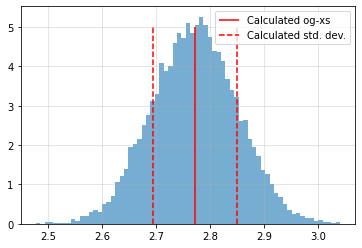

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.grid(alpha=0.4)
plt.hist(one_group_xs_samples, bins=69, density=True, alpha=0.6)
plt.vlines(ogxs, 0, 5, color='red', label='Calculated og-xs')
plt.vlines([ogxs - 0.028 * ogxs, ogxs + 0.028 * ogxs], 0, 5, color='red', ls='dashed', label='Calculated std. dev.')
plt.legend()
plt.show()